In [1]:
import os
import mediapipe as mp
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import cv2
import random
import time
from PIL import Image
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Library Constants
BaseOptions = mp.tasks.BaseOptions
HandLandmarker = mp.tasks.vision.HandLandmarker
HandLandmarkPoints = mp.solutions.hands.HandLandmark
HandLandmarkerOptions = mp.tasks.vision.HandLandmarkerOptions
VisionRunningMode = mp.tasks.vision.RunningMode
DrawingUtil = mp.solutions.drawing_utils

In [3]:
# base_options = BaseOptions(model_asset_path='data/hand_landmarker.task')
# options = HandLandmarkerOptions(base_options=base_options,
#                                         num_hands=2)

# detector = HandLandmarker.create_from_options(options)
# def convert_detection_result(detection_result, image):
#         """
#         Draws all the landmarks on the hand
#         Args:
#             image (Image): Image to draw on
#             detection_result (HandLandmarkerResult): HandLandmarker detection results
#         """
#         # Get a list of the landmarks
#         hand_landmarks_list = detection_result.hand_landmarks
        
#         # Loop through the detected hands to visualize.
#         listofpoints = []
#         for idx in range(len(hand_landmarks_list)):
#             hand_landmarks = hand_landmarks_list[idx]
#             for landmark in hand_landmarks:
#                   listofpoints.append(landmark.x)
#                   listofpoints.append(landmark.y)
#                   listofpoints.append(landmark.z)
        

#         return "Nothing Here"

In [4]:
import cv2
import mediapipe as mp
mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands

base_options = BaseOptions(model_asset_path='data/hand_landmarker.task')
options = HandLandmarkerOptions(base_options=base_options,
                                        num_hands=2)

detector = HandLandmarker.create_from_options(options)
def convert_detection_result(detection_result, image):
        """
        Draws all the landmarks on the hand
        Args:
            image (Image): Image to draw on
            detection_result (HandLandmarkerResult): HandLandmarker detection results
        """
        # Get a list of the landmarks
        hand_landmarks_list = detection_result.hand_landmarks
        
        for idx in range(len(hand_landmarks_list)):
            #NOTE this only works for one hand
            listofpointstoreturn = []
            hand_landmarks = hand_landmarks_list[idx]

            # Save the landmarks into a NormalizedLandmarkList
            hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
            hand_landmarks_proto.landmark.extend([
            landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
            ])
            # results = mp_hands.Hands.process(image = image)

            if hand_landmarks:
                for landmrk in hand_landmarks:
                    # for ids, landmrk in enumerate(hand_landmarks.landmark):
                        # print(ids, landmrk)
                    listofpointstoreturn.append(landmrk.x)
                    listofpointstoreturn.append(landmrk.y)
                    listofpointstoreturn.append(landmrk.z)
                return listofpointstoreturn
        
        return "Nothing Here"

I0000 00:00:1715139892.999078       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [5]:
def returndatapoints(image):
    to_detect = mp.Image(image_format=mp.ImageFormat.SRGB, data=image)
    results = detector.detect(to_detect)            
    # Draw the hand landmarks
    points = convert_detection_result(results, image)
    if points == "Nothing Here":
        border_size = 150
        frame = cv2.copyMakeBorder(image, top=border_size, 
                                bottom=border_size, left=border_size, 
                                right=border_size,
                                borderType=cv2.BORDER_CONSTANT, 
                                value=[0, 0, 0]
        )
        to_detect = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame)
        results = detector.detect(to_detect) 
        points = convert_detection_result(results, frame)
    return points


In [6]:

file_path = "data/raw_asl_hands/c/hand2_c_dif_seg_2_cropped.jpeg"
img = cv2.imread(file_path)
len(returndatapoints(image = img))
#Planning on seperating the xyz coordinates into seperate columns


63

In [7]:
twodarray = []
dfcolnames = []
for i in range(1,22):
    for j in ["x","y","z"]:
        dfcolnames.append(j+str(i))
dfcolnames.append("label")

# Iterates over every file in the raw_asl_hands folder
for folder in ["a","b","c","d","e","f","g","h","i","j",
               "k","l","m","n","o","p","q","r","s","t",
               "u","v","w","x","y","z"]:
    directory = 'data/raw_asl_hands/' + folder + "/"
    # Iterate over files in
    # that directory
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        # Checking if it is a file
        if os.path.isfile(f):
            file_path = directory + filename
            #print(file_path)
            img = cv2.imread(file_path)
            #print(returndatapoints(image = img))
            goodvarname = returndatapoints(img)
            if goodvarname != "Nothing Here" and len(goodvarname) == 63:
                goodvarname.append(folder)
                twodarray.append(goodvarname)


df = pd.DataFrame(twodarray, columns = dfcolnames)
#print(dfcolnames)
                



In [7]:
#df.to_csv('data/cleanhands.csv', index=False) 

In [8]:
df["label"].value_counts()

label
l    28
a    20
k    19
p    11
y    10
h     9
t     8
c     7
b     2
r     1
z     1
Name: count, dtype: int64

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

df = pd.read_csv("data/acquired_hands.csv")
all = df.loc[:, df.columns != "label"]
selected = []
to_add = len(all)
y_train = df["label"]
scorelist = []

model = KNeighborsClassifier(n_neighbors=13)
# Perform forward selection
while to_add > 0:
    best_feature = None
    best_score = 0
    for feature in all:
        if feature not in selected:
            combined_features = selected + [feature]
            X_train, X_test, y_train, y_test = train_test_split(df[combined_features], df["label"], test_size= 0.2, random_state=5)
            #print(combined_features)
            model.fit(X_train, y_train)
            model_score = model.score(X_test, y_test)
            #print("Features:", selected, "+", feature + ", Score:", model_score)
            if model_score > best_score:
                best_score = model_score
                best_feature = feature
    
    # Append best feature to model
    if(not best_feature):
        break
       
    
    selected.append(best_feature)
    print("Added best feature:", best_feature + ", Current feature list:", selected, "Current Score:", best_score)
    scorelist.append(best_score)
    to_add -= 1
# Print final feature score
X_train, X_test, y_train, y_test = train_test_split(df[combined_features], df["label"], test_size= 0.2, random_state=5)
model.fit(X_train, y_train)
initial_score = model.score(X_test, y_test)

print("Final features:", selected, "Score:", initial_score)

Added best feature: x15, Current feature list: ['x15'] Current Score: 0.22916666666666666
Added best feature: x1, Current feature list: ['x15', 'x1'] Current Score: 0.4875
Added best feature: x7, Current feature list: ['x15', 'x1', 'x7'] Current Score: 0.5625
Added best feature: x21, Current feature list: ['x15', 'x1', 'x7', 'x21'] Current Score: 0.6125
Added best feature: y17, Current feature list: ['x15', 'x1', 'x7', 'x21', 'y17'] Current Score: 0.65
Added best feature: y4, Current feature list: ['x15', 'x1', 'x7', 'x21', 'y17', 'y4'] Current Score: 0.7
Added best feature: y20, Current feature list: ['x15', 'x1', 'x7', 'x21', 'y17', 'y4', 'y20'] Current Score: 0.7333333333333333
Added best feature: x4, Current feature list: ['x15', 'x1', 'x7', 'x21', 'y17', 'y4', 'y20', 'x4'] Current Score: 0.75
Added best feature: y9, Current feature list: ['x15', 'x1', 'x7', 'x21', 'y17', 'y4', 'y20', 'x4', 'y9'] Current Score: 0.7708333333333334
Added best feature: z4, Current feature list: ['x15'

In [12]:
scorelist[31]

0.8458333333333333

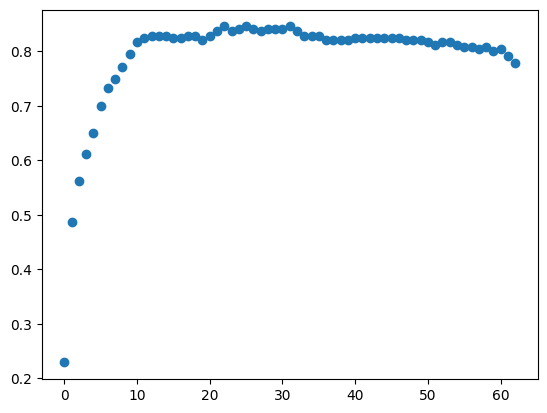

In [13]:
plt.scatter(range(len(scorelist)),scorelist)

In [14]:
X = df.loc[:, df.columns != "label"]
y = df["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

In [21]:
k_values = list(range(1,14,2))

# Initiallize an empty list for our scores
cv_scores = []

#Perform 5-fold cross validation
for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(model, X_train, y_train,cv =5, scoring = "accuracy")
    # print(scores)
    cv_scores.append(scores.mean())

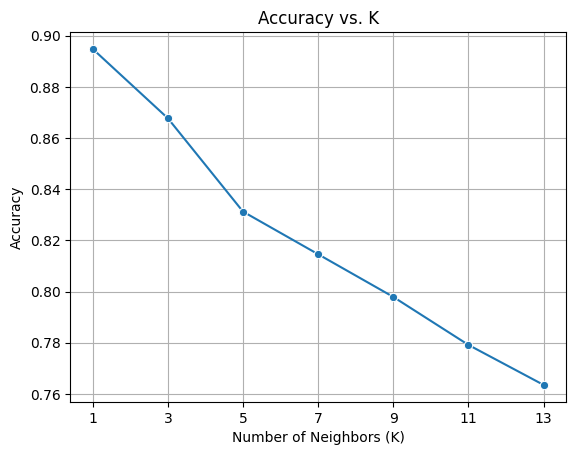

In [22]:
sns.lineplot(x=k_values, y=cv_scores, marker='o')
plt.title('Accuracy vs. K')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Accuracy')
plt.xticks(k_values)
plt.grid(True)

In [24]:
X = df.loc[:, df.columns != "label"]
y = df["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)
model = KNeighborsClassifier(n_neighbors=7)
model = model.fit(X_train, y_train)
scores = cross_val_score(model, X_train, y_train,cv =5, scoring = "accuracy")
scores.mean()

0.8145833333333334

In [25]:
something_test = pd.read_csv("data/acquired_data/a.csv")
something_else = something_test.loc[:,list(X_train.columns)]
model.predict(something_else)


array(['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a',
       'a', 'a', 'a', 'b', 'a', 'a', 'x', 'a', 'a', 'a', 'a', 'a', 'a',
       'a', 'a', 'a', 'a', 'a', 'm', 'a', 'a', 'a', 'a', 'a', 'a', 'a',
       'a', 'a', 'a', 'i', 'a', 'a', 'a', 'a', 'a', 'a', 'a'],
      dtype=object)

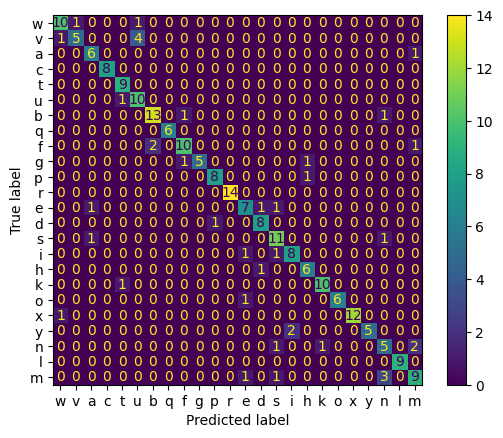

In [26]:
y_pred = model.predict(X_test)

# Create a confusion matrix
labels = df["label"].unique()
conf_mat = confusion_matrix(y_test, y_pred, labels=labels)

disp = ConfusionMatrixDisplay(conf_mat, display_labels=labels)
disp.plot()

In [7]:
dfcolnames = []
for i in range(1,22):
    for j in ["x","y","z"]:
        dfcolnames.append(j+str(i))
dfcolnames.append("label")

In [8]:
directory = 'data/acquired_data/'
combined_acquired_df = pd.DataFrame()
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # Checking if it is a file
    if os.path.isfile(f):
        file_path = directory + filename
        df_temp = pd.read_csv(file_path)
        combined_acquired_df = pd.concat([combined_acquired_df, df_temp], ignore_index = True)
        combined_acquired_df.reset_index()


In [10]:
combined_acquired_df.to_csv('data/acquired_hands.csv', index=False) 

In [9]:
combined_acquired_df["label"].value_counts()

label
w    50
v    50
l    50
n    50
y    50
x    50
o    50
k    50
h    50
i    50
s    50
d    50
e    50
r    50
p    50
g    50
f    50
q    50
b    50
u    50
t    50
c    50
a    50
m    50
Name: count, dtype: int64